# Log-N_Gaussian_log-N 3-component Mixture Model

In [1]:
import numpy as np
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import invgamma
import matplotlib.pyplot as plt
import copy

In [3]:
# Define log_Normal pdf
def log_Normal(x, true_mu, true_sigma):
    log_norm = (np.exp(-(np.log(abs(x)) - true_mu)**2 / (2 * true_sigma**2))) / (abs(x) * true_sigma * np.sqrt(2 * np.pi))
    return log_norm


# Define Function for simulating dataset
def sim_data_log_N_Gauss_mix(n_samples, true_mu1, true_mu2, true_mu3, true_sigma1, true_sigma2, true_sigma3, true_w1, true_w2, true_w3):
    # To sample from a mixture model, we simply sample from each individual component with the given weights 
    # Generate n data samples
    all_data_set = []
    cat_1 = []
    cat_2 = []
    cat_3 = []

    for i in range(n_samples):
        # Select component to sample from
        component = np.random.choice([1,2,3], 1, p = [true_w1, true_w2, true_w3])[0]
        # sample a value from the component
        if component == 1:
            sampled_val = np.random.lognormal(true_mu1, true_sigma1)
            # sampled_val = np.exp(sampled_val)
            cat_1.append(sampled_val)
            all_data_set.append(sampled_val)
        elif component == 2:
            sampled_val = np.random.normal(true_mu2, true_sigma2)
            all_data_set.append(sampled_val)
            cat_2.append(sampled_val)
        elif component == 3:
            sampled_val = -np.random.lognormal(true_mu3, true_sigma3)
            cat_3.append(sampled_val)
            all_data_set.append(sampled_val)
            
    all_data_set = np.array(all_data_set)
    cat_1 = np.array(cat_1)
    cat_2 = np.array(cat_2)
    cat_3 = np.array(cat_3)
    return [all_data_set, cat_1, cat_2, cat_3]


# Define function for thresholding components of dataset using Otsu's Method
def Otsu_method(data, n_bins):
    var_B_max = 0
    k1_max = 0
    k2_max = 0
    
    # Create histogram of data with defined number of bins and normalize to form probability density
    count, bins, ignored = plt.hist(data, bins = n_bins, density = True)
    for i in range(1, (len(bins)-2)):
        k2 = bins[i]
        for j in range(0, i):
            k1 = bins[j]
            
            w_0 = np.sum(count[0:j])
            w_1 = np.sum(count[j:i])
            w_2 = np.sum(count[i:])
            
            mu_0 = np.sum(bins[0:j]*(count[0:j]/w_0))
            mu_1 = np.sum(bins[j:i]*(count[j:i]/w_1))
            mu_2 = np.sum(bins[i:-1]*(count[i:]/w_2))
            
            var_0 = np.sum((bins[0:j] - mu_0)**2 * (count[0:j]/w_0))
            var_1 = np.sum((bins[j:i] - mu_1)**2 * (count[j:i]/w_1))
            var_2 = np.sum((bins[i:-1] - mu_2)**2 * (count[i:]/w_2))
            
            mu_T = w_0*mu_0 + w_1*mu_1 + w_2*mu_2
                
            var_B = w_0*(mu_0 - mu_T)**2 + w_1*(mu_1 - mu_T)**2 + w_2*(mu_2 - mu_T)**2
            if var_B > var_B_max:
                var_B_max = var_B
                k1_max = k1
                k2_max = k2
                
    return [var_B_max, k1_max, k2_max]

# Plot simulated dataset and "true mixture model" distribution

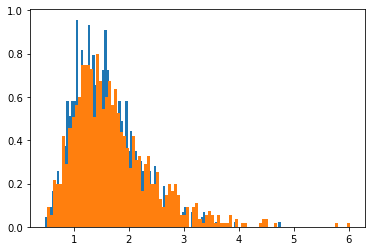

In [4]:
true_mu_1 = 0.3873
true_sigma_1 = 0.3624
true_w_1 = 0.3351

true_mu_2 = 0
true_sigma_2 = 0.3387
true_w_2 = (1-0.271-0.3351)

true_mu_3 = 0.4369
true_sigma_3 = 0.3918
true_w_3 = 0.271

sim_vals = np.random.lognormal(true_mu_1, true_sigma_1, 1000)
count, bins1, ignored = plt.hist(sim_vals, bins = 100, density = True)

sim_vals = np.random.lognormal(true_mu_3, true_sigma_3, 1000)
count, bins2, ignored = plt.hist(sim_vals, bins = 100, density = True)

x = np.linspace(-max(max(bins1), max(bins2)), max(max(bins1), max(bins2)), 1000)

# Obtain log normal PDFs
log_norm_positive = log_Normal(x[np.where(x > 0)], true_mu_1, true_sigma_1)
log_norm_negative = log_Normal(x[np.where(x < 0)], true_mu_3, true_sigma_3)

# Pad with zeros
log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(x) - len(log_norm_negative))])
log_norm_positive = np.concatenate([np.zeros(len(x) - len(log_norm_positive)), log_norm_positive])

log_N_Gauss_mixture = true_w_1*log_norm_positive + true_w_2*norm.pdf(x, true_mu_2, true_sigma_2) + true_w_3*log_norm_negative

In [5]:
def log_N_Gauss_mix(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, w1, w2, w3):
    log_norm_positive = log_Normal(x[np.where(x > 0)], mu1, sigma1)
    log_norm_negative = log_Normal(x[np.where(x < 0)], mu3, sigma3)
    # Pad with zeros
    log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(x) - len(log_norm_negative))])
    log_norm_positive = np.concatenate([np.zeros(len(x) - len(log_norm_positive)), log_norm_positive])
    
    # Compute PDF
    log_N_Gauss_mixture = w1*log_norm_positive + w2*norm.pdf(x, mu2, sigma2) + w3*log_norm_negative
    return log_N_Gauss_mixture

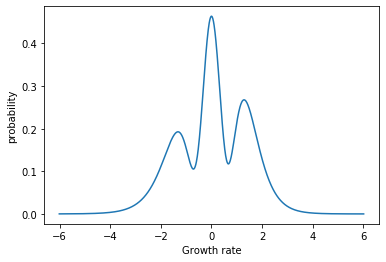

In [6]:
plt.plot(x, log_N_Gauss_mixture)
# plt.xlim(min(x),max(x))
# plt.ylim(top = 0.2)
plt.xlabel('Growth rate')
plt.ylabel('probability')
plt.show()

In [7]:
n_samples = 10000
[all_data_set, cat_1, cat_2, cat_3] = sim_data_log_N_Gauss_mix(n_samples, true_mu_1, true_mu_2, true_mu_3, true_sigma_1, true_sigma_2, true_sigma_3, true_w_1, true_w_2, true_w_3)

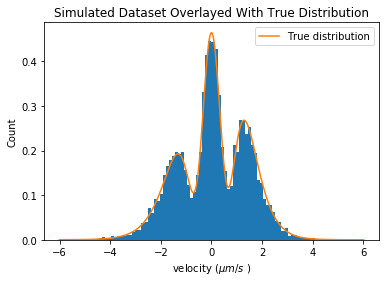

In [12]:
plt.hist(all_data_set, bins = 100, range = (min(x), max(x)), density = True)
plt.plot(x, log_N_Gauss_mixture, label='True distribution')
plt.title('Simulated Dataset Overlayed With True Distribution')
plt.xlabel(r'velocity ($\mu m/s$ )')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


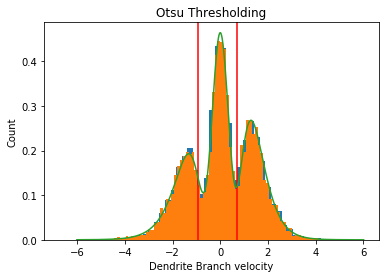

k1:  -0.919 ; k2:  0.714


In [41]:
# Compute threshold values and plot using Otsu's Method
[var_B_max, k1, k2] = Otsu_method(all_data_set, 50)

plt.hist(all_data_set, bins = 100, range = (min(x), max(x)), density = True)
plt.axvline(k1, color = 'r')
plt.axvline(k2, color = 'r')
plt.plot(x, log_N_Gauss_mixture)
plt.title('Otsu Thresholding')
plt.xlabel('Dendrite Branch velocity')
plt.ylabel('Count')
plt.show()

print('k1: ', round(k1,3), '; k2: ', round(k2,3))

# Gibbs Sampling Algorithm

In [14]:
# Define functions for sampling from distributions
# Sample n categorical random variables into 2 categories with probabilities p1 and p2 (n = len(data_set))
def Categorical_var(n, neg_len, p1, p2, p3):
    cat_var = []
    for i in range(n):
        if type(p1) and type(p2) and type(p3) == float:
            s_i = np.random.multinomial(1,[p1, p2, p3])
            s_i = np.where(s_i == 1)[0][0] + 1
        else:
            # s_i = np.random.multinomial(1,[p1[i], p2[i], p3[i]])  # ***Multinomial distribution has some bug!!!
            if i < neg_len:
                s_i = np.random.multinomial(1, [p2[i],p3[i]])
                s_i = np.where(s_i == 1)[0][0] + 2
                    
            else:
                s_i = np.random.multinomial(1, [p1[i],p2[i]])
                s_i = np.where(s_i == 1)[0][0] + 1
        
        cat_var.append(s_i)
    cat_var = np.array(cat_var)
    return cat_var

# Sample precision (tao) parameter from inverse gamma posterior of Gaussian likelihood model
def tau_param(alpha, beta, A, set_A, mean, n_0, mu_0):
    alpha_prime = alpha + A/2
    beta_prime = beta + 0.5*sum((set_A - mean)**2) + (((A*n_0)/(2*(A + n_0)))*(mean - mu_0)**2)
    tao_param = np.random.gamma(alpha_prime, 1/beta_prime)
    return tao_param

#Sample mu parameter from normal posterior using previously sampled sigma value
def mu_param(A, tau, mean, n_0, mu_0):
    mu = (A/(A + n_0))*mean + (n_0/(A + n_0))*mu_0
    var = 1/(A*tau + n_0*tau)
    mu_param = np.random.normal(mu, np.sqrt(var))
    return mu_param

# Define function to sample mu and sigma parameters from normal_inverse_gamma posterior
# from data set generated from Gaussian distribution 
def sampling_normal_inverse_gamma_posterior(data_set, n_iter):
    mu_vals = []
    var_vals = []
    
    # define prior variables and initial condition for gamma and Gaussian posteriors
    mu_0 = np.mean(data_set)

    # tau_0 = len(data_set)
    n_0 = 2
    
    alpha = len(data_set)/2
    beta = sum((data_set - mu_0)**2)/2
    
    A = len(data_set)
    y_mean = np.mean(data_set)
    
    for i in range(n_iter):
        # Sample variance (sigma^2) using inverse gamma posterior
        tau = tau_param(alpha, beta, A, data_set, y_mean, n_0, mu_0)
        var = 1/tau
        var_vals.append(var)
        
        # Sample mu using sigma values and normal posterior
        mu = mu_param(A, tau, y_mean, n_0, mu_0)
        mu_vals.append(mu)
        
    mu_vals = np.array(mu_vals)
    sigma_vals = np.sqrt(np.array(var_vals))
    return [mu_vals, sigma_vals]

In [15]:
def Gibbs_sampling_gauss_mix(data_set, n_iter, initialization='Otsu', plots=False):
    # Initialize uniform categorical variables
    cat_var = []
    # Initialize parameter vectors
    mu_1_vals = []
    mu_2_vals = []
    mu_3_vals = []
    
    sigma_1_vals = []
    sigma_2_vals = []  
    sigma_3_vals = []
    
    w_1_vals = []
    w_2_vals = []
    w_3_vals = []
    
    
    # *** Sort data set from least to greatest (negative values preceding positive values) ***
    data_set = np.sort(data_set)

    # Set initial probabilities to sample initial categorical variables from uniform categorical distribution, 
    # but setting p(log-N) = 0 for data < 0, and p(negative log-N) = 0 for data > 0
    pos_len = len(data_set[np.where(data_set>0)])
    neg_len = len(data_set[np.where(data_set<0)])
    
    # mu_init = 0
    # sigma_init = 8
    
    n = len(data_set)
    Neg_len = len(data_set[np.where(data_set<0)])
    
    if initialization == 'random':
        p1 = np.concatenate([np.zeros(neg_len), np.repeat(0.5, pos_len)])
        p2 = 0.5
        p3 = np.concatenate([np.repeat(0.5, neg_len), np.zeros(pos_len)])
        
        p1 = p1/(p1+p2+p3)
        p2 = p2/(p1+p2+p3)
        p3 = p3/(p1+p2+p3)
            
        cat_var = Categorical_var(n, Neg_len, p1, p2, p3)
        
    # p1 = np.concatenate([np.zeros(neg_len), np.repeat(0.2, pos_len)])
    # p2 = (1/(np.sqrt(2*np.pi)*sigma_init))*np.exp(-(data_set - mu_init)**2/(2*sigma_init**2))
    # p3 = np.concatenate([np.repeat(0.2, neg_len), np.zeros(pos_len)])
    
    
    # Run Gibbs sampling algorithm for n iterations 
    for i in range(n_iter):
        if i % 100 == 0:
            print('iteration: ', i)
            
        if i == 0:
            if initialization == 'Otsu':
                # Assign initial categories using Otsu's thresholding method
                # Sample categorical variables using initial probabilities
                # cat_var = Categorical_var(n, p1, p2, p3)
            
                [var_B_max, k1, k2] = Otsu_method(data_set, 50)
                print('k1: ', k1, 'k2: ', k2)
            
                set_A3 = data_set[np.where(data_set <= k1)]
                set_A2 = data_set[np.where(data_set > k1)]
                set_A2 = data_set[np.where(data_set <= k2)]
                set_A1 = data_set[np.where(data_set > k2)]
                
            if initialization == 'random':
                set_A1 = data_set[np.where(cat_var == 1)]
                set_A2 = data_set[np.where(cat_var == 2)] 
                set_A3 = data_set[np.where(cat_var == 3)] 

        else:
            # generate log-Normal pdfs given newly sampled weights and theta values
            # Obtain log normal PDFs
            log_norm_positive = log_Normal(data_set[np.where(data_set > 0)], mu_1[0], sigma_1[0])
            log_norm_negative = log_Normal(data_set[np.where(data_set < 0)], mu_3[0], sigma_3[0])

            # Pad with zeros
            log_norm_positive = np.concatenate([np.zeros(len(data_set) - len(log_norm_positive)), log_norm_positive])
            log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(data_set) - len(log_norm_negative))])
            
            # Update categorical assignments using newly sampled weights and theta values 
            cat_var = []
            p1 = w_1*log_norm_positive
            p2 = w_2*(1/(np.sqrt(2*np.pi)*sigma_2[0]))*np.exp(-(data_set - mu_2[0])**2/(2*sigma_2[0]**2))
            p3 = w_3*log_norm_negative
            
            p1 = p1/(p1+p2+p3)
            p2 = p2/(p1+p2+p3)
            p3 = p3/(p1+p2+p3)
            
            cat_var = Categorical_var(n, Neg_len, p1, p2, p3)
            
            # Compute number of elements in each component and mean of the elements
            set_A1 = data_set[np.where(cat_var == 1)]
            set_A2 = data_set[np.where(cat_var == 2)] 
            set_A3 = data_set[np.where(cat_var == 3)] 
        # Compute number of elements in each component and mean of the elements

        # Sample sigma and mu for categories 1,2, and 3 using categorical assignments, inverse gamma posterior for sigma,
        # and normal posterior (dependent on sigma) for mu
        # For log-Normal distrubution, ln(data_set) ~ N(mu1, sigma1), so take ln(set_A1)
        # For negative log-Normal distribution, ln(abs(data_set) ~ N(mu3, sigma3), so take ln(abs(set_A3))
        [mu_1, sigma_1] = sampling_normal_inverse_gamma_posterior(np.log(set_A1), 1)
        mu_1_vals.append(mu_1[0])
        sigma_1_vals.append(sigma_1[0])
        
        [mu_2, sigma_2] = sampling_normal_inverse_gamma_posterior(set_A2, 1)
        mu_2_vals.append(mu_2[0])
        sigma_2_vals.append(sigma_2[0])
        
        [mu_3, sigma_3] = sampling_normal_inverse_gamma_posterior(np.log(abs(set_A3)), 1)
        mu_3_vals.append(mu_3[0])
        sigma_3_vals.append(sigma_3[0])

        # Sample weights using categorical assignments and Dirichlet posterior
        weights = np.random.dirichlet([len(set_A1) + 1, len(set_A2) + 1, len(set_A3) + 1], 1)[0]
        w_1 = weights[0]
        w_1_vals.append(w_1)
    
        w_2 = weights[1]
        w_2_vals.append(w_2)
        
        w_3 = weights[2]
        w_3_vals.append(w_3)

        
        if plots:
            if i < 50:
                # x defined outside of function
                log_N_Gauss_mix_pdf = log_N_Gauss_mix(x, mu_1, mu_2, mu_3, sigma_1, sigma_2, sigma_3, w_1, w_2, w_3)
                cat_1 = data_set[np.where(cat_var == 1)]
                cat_2 = data_set[np.where(cat_var == 2)]
                cat_3 = data_set[np.where(cat_var == 3)]

                # Plot pdf and categorical assignments
                fig, (ax1, ax2) = plt.subplots(1,2)
                fig.suptitle(('Evolving posterior PDF; ', 'iteration: ', i))
                ax1.plot(x, log_N_Gauss_mix_pdf)
                ax2.plot(x, log_N_Gauss_mix_pdf)
                ax2.hist(cat_2, density = True, color = 'blue')
                ax2.hist(cat_1, density = True, color = 'red')
                ax2.hist(cat_3, density = True, color = 'orange')
        
    mu_1_vals = np.array(mu_1_vals)
    mu_2_vals = np.array(mu_2_vals)
    mu_3_vals = np.array(mu_3_vals)
    
    sigma_1_vals = np.array(sigma_1_vals)
    sigma_2_vals = np.array(sigma_2_vals)
    sigma_3_vals = np.array(sigma_3_vals)
    
    w_1_vals = np.array(w_1_vals)
    w_2_vals = np.array(w_2_vals)
    w_3_vals = np.array(w_3_vals)
    
    cat_var = np.array(cat_var)
        
    return [mu_1_vals, mu_2_vals, mu_3_vals, sigma_1_vals, sigma_2_vals, sigma_3_vals, w_1_vals, w_2_vals, w_3_vals, cat_var]

chain:  0
iteration:  0


C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


k1:  -0.9194034263725079 k2:  0.7141158003891759
iteration:  100
iteration:  200
iteration:  300
iteration:  400


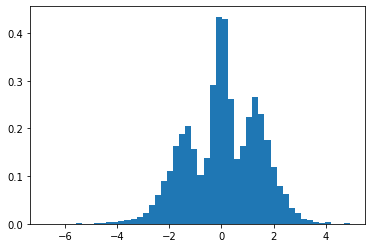

In [42]:
# Run Gibbs sampler with specified number of chains and iterations per chain
n_iter = 500
n_chains = 1
initialization = 'Otsu'

mu_1_chain = []
mu_2_chain = []
mu_3_chain = []
sigma_1_chain = []
sigma_2_chain = []
sigma_3_chain = []
w_1_chain = []
w_2_chain = []
w_3_chain = []

for i in range(n_chains):
    print('chain: ', i)
    if i == 0:
        plots = False
    else:
        plots = False
        
    [mu_1_vals, mu_2_vals, mu_3_vals, sigma_1_vals, sigma_2_vals, sigma_3_vals, w_1_vals, w_2_vals, w_3_vals, cat_var] = Gibbs_sampling_gauss_mix(all_data_set, n_iter, initialization, plots)
    mu_1_chain.append([mu_1_vals])
    mu_2_chain.append([mu_2_vals])
    mu_3_chain.append([mu_3_vals])
    sigma_1_chain.append([sigma_1_vals])
    sigma_2_chain.append([sigma_2_vals])
    sigma_3_chain.append([sigma_3_vals])
    w_1_chain.append([w_1_vals])
    w_2_chain.append([w_2_vals])
    w_3_chain.append([w_3_vals])

iteration:  0
k1:  -1.7356612839779686 k2:  1.445484489957451


C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dfrid\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


iteration:  100
iteration:  200
iteration:  300
iteration:  400


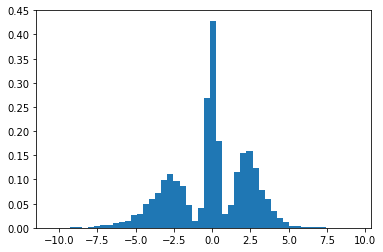

In [79]:
n_iter = 500
initialization = 'Otsu'
[mu_1_vals, mu_2_vals, mu_3_vals, sigma_1_vals, sigma_2_vals, sigma_3_vals, w_1_vals, w_2_vals, w_3_vals, cat_var] = Gibbs_sampling_gauss_mix(all_data_set, n_iter, initialization)

mu_growing 99% conf int:  (0.3598, 0.3991)
mu_paused 99% conf int:  (-0.0163, 0.0178)
mu_shrinking 99% conf int:  (0.419, 0.4647)
mu_growing std dev:  0.0076
mu_paused std dev:  0.0066
mu_shrinking std dev:  0.0088


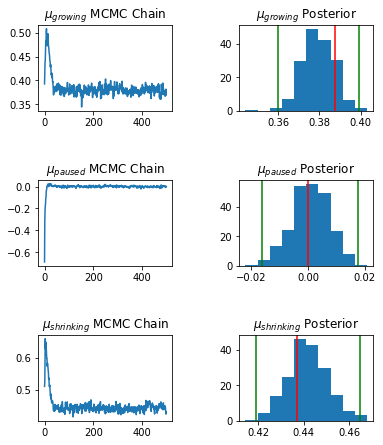

In [52]:
confidence = 0.99
n = len(mu_1_vals[50:])
m = np.mean(mu_1_vals[50:])
std_err = np.std(mu_1_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

mu_1_conf_int = [m-h, m+h]
print('mu_growing 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(mu_2_vals[50:])
m = np.mean(mu_2_vals[50:])
std_err = np.std(mu_2_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

mu_2_conf_int = [m-h, m+h]
print('mu_paused 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(mu_3_vals[50:])
m = np.mean(mu_3_vals[50:])
std_err = np.std(mu_3_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

mu_3_conf_int = [m-h, m+h]
print('mu_shrinking 99% conf int: ',(round(m-h,4), round(m+h,4)))

print('mu_growing std dev: ', round(np.std(mu_1_vals[50:]), 4))
print('mu_paused std dev: ', round(np.std(mu_2_vals[50:]), 4))
print('mu_shrinking std dev: ', round(np.std(mu_3_vals[50:]), 4))


for i in range(n_chains):
    mu_1_vals = mu_1_chain[i][0]
    mu_2_vals = mu_2_chain[i][0]
    mu_3_vals = mu_3_chain[i][0]
    
    sigma_1_vals = sigma_1_chain[i][0]
    sigma_2_vals = sigma_2_chain[i][0]
    sigma_3_vals = sigma_3_chain[i][0]
    
    w_1_vals = w_1_chain[i][0]
    w_2_vals = w_2_chain[i][0]
    w_3_vals = w_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(mu_1_vals)
    plt.title(r'$\mu_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(mu_1_vals[50:], density=True)
    plt.axvline(true_mu_1, color = 'r')
    plt.axvline(mu_1_conf_int[0], color='g')
    plt.axvline(mu_1_conf_int[1], color='g')
    plt.title(r'$\mu_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(mu_2_vals)
    plt.title(r'$\mu_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(mu_2_vals[50:], density=True)
    plt.axvline(true_mu_2, color = 'r')
    plt.axvline(mu_2_conf_int[0], color='g')
    plt.axvline(mu_2_conf_int[1], color='g')
    plt.title(r'$\mu_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(mu_3_vals)
    plt.title(r'$\mu_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(mu_3_vals[50:], density=True)
    plt.axvline(true_mu_3, color = 'r')
    plt.axvline(mu_3_conf_int[0], color='g')
    plt.axvline(mu_3_conf_int[1], color='g')
    plt.title(r'$\mu_{shrinking}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()

sigma_1_vals 99% conf int:  (0.3537, 0.3794)
sigma_2_vals 99% conf int:  (0.3179, 0.3459)
sigma_1_vals 99% conf int:  (0.3733, 0.4036)
sigma_growing std dev:  0.005
sigma_paused std dev:  0.0054
sigma_shrinking std dev:  0.0059


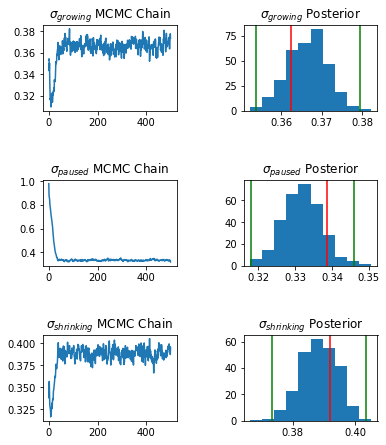

In [55]:
confidence = 0.99
n = len(sigma_1_vals[50:])
m = np.mean(sigma_1_vals[50:])
std_err = np.std(sigma_1_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

sigma_1_conf_int = [m-h, m+h]
print('sigma_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(sigma_2_vals[50:])
m = np.mean(sigma_2_vals[50:])
std_err = np.std(sigma_2_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

sigma_2_conf_int = [m-h, m+h]
print('sigma_2_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(sigma_3_vals[50:])
m = np.mean(sigma_3_vals[50:])
std_err = np.std(sigma_3_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

sigma_3_conf_int = [m-h, m+h]
print('sigma_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

print('sigma_growing std dev: ', round(np.std(sigma_1_vals[50:]), 4))
print('sigma_paused std dev: ', round(np.std(sigma_2_vals[50:]), 4))
print('sigma_shrinking std dev: ', round(np.std(sigma_3_vals[50:]), 4))


for i in range(n_chains):
    mu_1_vals = mu_1_chain[i][0]
    mu_2_vals = mu_2_chain[i][0]
    mu_3_vals = mu_3_chain[i][0]
    
    sigma_1_vals = sigma_1_chain[i][0]
    sigma_2_vals = sigma_2_chain[i][0]
    sigma_3_vals = sigma_3_chain[i][0]
    
    w_1_vals = w_1_chain[i][0]
    w_2_vals = w_2_chain[i][0]
    w_3_vals = w_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(sigma_1_vals)
    plt.title(r'$\sigma_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(sigma_1_vals[50:], density=True)
    plt.axvline(true_sigma_1, color = 'r')
    plt.axvline(sigma_1_conf_int[0], color='g')
    plt.axvline(sigma_1_conf_int[1], color='g')
    plt.title(r'$\sigma_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(sigma_2_vals)
    plt.title(r'$\sigma_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(sigma_2_vals[50:], density=True)
    plt.axvline(true_sigma_2, color = 'r')
    plt.axvline(sigma_2_conf_int[0], color='g')
    plt.axvline(sigma_2_conf_int[1], color='g')
    plt.title(r'$\sigma_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(sigma_3_vals)
    plt.title(r'$\sigma_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(sigma_3_vals[50:], density=True)
    plt.axvline(true_sigma_3, color = 'r')
    plt.axvline(sigma_3_conf_int[0], color='g')
    plt.axvline(sigma_3_conf_int[1], color='g')
    plt.title(r'$\sigma_{shrinking}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()

w_1_vals 99% conf int:  (0.3179, 0.3434)
w_2_vals 99% conf int:  (0.3797, 0.4084)
w_1_vals 99% conf int:  (0.2629, 0.2876)
sigma_growing std dev:  0.0049
sigma_paused std dev:  0.0055
sigma_shrinking std dev:  0.0048


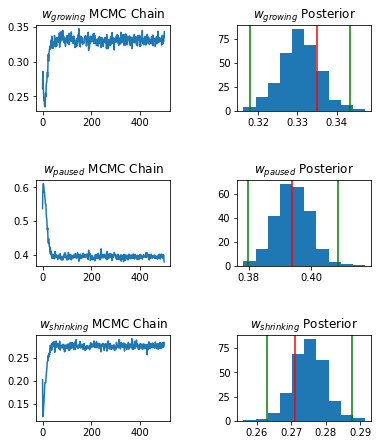

In [56]:
confidence = 0.99
n = len(w_1_vals[50:])
m = np.mean(w_1_vals[50:])
std_err = np.std(w_1_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

w_1_conf_int = [m-h, m+h]
print('w_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(w_2_vals[50:])
m = np.mean(w_2_vals[50:])
std_err = np.std(w_2_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

w_2_conf_int = [m-h, m+h]
print('w_2_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))


confidence = 0.99
n = len(w_3_vals[50:])
m = np.mean(w_3_vals[50:])
std_err = np.std(w_3_vals[50:])
h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)

w_3_conf_int = [m-h, m+h]
print('w_1_vals 99% conf int: ',(round(m-h,4), round(m+h,4)))

print('sigma_growing std dev: ', round(np.std(w_1_vals[50:]), 4))
print('sigma_paused std dev: ', round(np.std(w_2_vals[50:]), 4))
print('sigma_shrinking std dev: ', round(np.std(w_3_vals[50:]), 4))

for i in range(n_chains):
    mu_1_vals = mu_1_chain[i][0]
    mu_2_vals = mu_2_chain[i][0]
    mu_3_vals = mu_3_chain[i][0]
    
    sigma_1_vals = sigma_1_chain[i][0]
    sigma_2_vals = sigma_2_chain[i][0]
    sigma_3_vals = sigma_3_chain[i][0]
    
    w_1_vals = w_1_chain[i][0]
    w_2_vals = w_2_chain[i][0]
    w_3_vals = w_3_chain[i][0]
    
    plt.subplot(321)
    plt.plot(w_1_vals)
    plt.title(r'$w_{growing}$ MCMC Chain')

    plt.subplot(322)
    plt.hist(w_1_vals[50:], density=True)
    plt.axvline(true_w_1, color = 'r')
    plt.axvline(w_1_conf_int[0], color='g')
    plt.axvline(w_1_conf_int[1], color='g')
    plt.title(r'$w_{growing}$ Posterior')

    plt.subplot(323)
    plt.plot(w_2_vals)
    plt.title(r'$w_{paused}$ MCMC Chain')

    plt.subplot(324)
    plt.hist(w_2_vals[50:], density=True)
    plt.axvline(true_w_2, color = 'r')
    plt.axvline(w_2_conf_int[0], color='g')
    plt.axvline(w_2_conf_int[1], color='g')
    plt.title(r'$w_{paused}$ Posterior')

    plt.subplot(325)
    plt.plot(w_3_vals)
    plt.title(r'$w_{shrinking}$ MCMC Chain')

    plt.subplot(326)
    plt.hist(w_3_vals[50:], density=True)
    plt.axvline(true_w_3, color = 'r')
    plt.axvline(w_3_conf_int[0], color='g')
    plt.axvline(w_3_conf_int[1], color='g')
    plt.title(r'$w_{shrinking}$ Posterior')

plt.subplots_adjust(top=1.5, wspace=0.5, hspace=0.8)
plt.show()

In [47]:
mu_1_mean = np.mean(mu_1_vals[50:])
mu_2_mean = np.mean(mu_2_vals[50:])
mu_3_mean = np.mean(mu_3_vals[50:])

sigma_1_mean = np.mean(sigma_1_vals[50:])
sigma_2_mean = np.mean(sigma_2_vals[50:])
sigma_3_mean = np.mean(sigma_3_vals[50:])

w_1_mean = np.mean(w_1_vals[50:])
w_2_mean = np.mean(w_2_vals[50:])
w_3_mean = np.mean(w_3_vals[50:])

In [48]:
# Experimental model
# Obtain log normal PDFs

log_norm_positive = log_Normal(x[np.where(x > 0)], mu_1_mean, sigma_1_mean)
log_norm_negative = log_Normal(x[np.where(x < 0)], mu_3_mean, sigma_3_mean)

# Pad with zeros
log_norm_negative = np.concatenate([log_norm_negative, np.zeros(len(x) - len(log_norm_negative))])
log_norm_positive = np.concatenate([np.zeros(len(x) - len(log_norm_positive)), log_norm_positive])

experimental_mixture = w_1_mean*log_norm_positive + w_2_mean*norm.pdf(x, mu_2_mean, sigma_2_mean) + w_3_mean*log_norm_negative

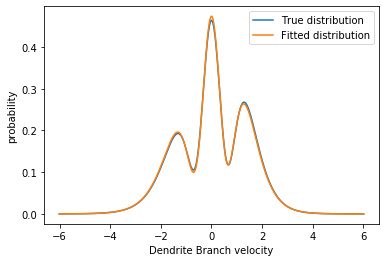

In [49]:
# Plot experimental model and true model
plt.plot(x, log_N_Gauss_mixture, label='True distribution')
plt.plot(x, experimental_mixture, label='Fitted distribution')
plt.xlabel('Dendrite Branch velocity')
plt.ylabel('probability')
# plt.xlim(min(x2),max(x2))
# plt.hist(all_data_set, bins = 100, density = True)
plt.legend(loc='upper right')
plt.show()